In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch_tools.datasets import *
import numpy as np
from PIL import Image
import os
from tqdm import tqdm
from torch_tools.training_methods import *
from sklearn.model_selection import train_test_split

In [3]:
# initialize dataloader for testing
flair, t1w, t1wce, t2w, labels = get_data_paths("./tables/nii_data_paths.csv")

x_train, x_test, y_train, y_test = train_test_split(flair, labels, 
                                            test_size = 0.2, random_state = 42)

train_table = (x_train, y_train)
test_table = (x_test, y_test)



train_set = flair_dataset(train_table, transform=None)
test_set = flair_dataset(test_table, transform=None)

train_loader = DataLoader(train_set, batch_size=10, shuffle=True)
test_loader = DataLoader(test_set, batch_size=10, shuffle=True)

train_set[0][0].shape

torch.Size([1, 100, 100, 100])

In [4]:
layer = nn.Sequential( 
    nn.Conv3d(1, 5, 5, stride=5, padding=0),
    nn.BatchNorm3d(5),
    nn.ReLU(inplace=True),
)
layer2 = nn.Sequential(
    nn.Conv3d(5, 3, 3, stride=3, padding=2),
    nn.BatchNorm3d(3),
    nn.ReLU(inplace=True),
    # maxpool reduces to a 4x4x4x3 hypervolume
    nn.MaxPool3d(2),
)
x = layer(next(iter(train_loader))[0])
x = layer2(x)
x.shape

torch.Size([10, 3, 4, 4, 4])

In [5]:
# define neural net
class austin_net(nn.Module):
    """ 
    this class implements an extremely simple 3d conv net
    inference using .forward()
    """
    def __init__(self):
        super(austin_net, self).__init__()
        self.conv = nn.Sequential(
            # first conv outputs a 1x5x20x20x20 hypervolume
            nn.Conv3d(1, 5, 5, stride=5, padding=0),
            nn.BatchNorm3d(5),
            nn.ReLU(inplace=True),
            # 2nd conv conv outputs a 8x8x8x3 hypervolume 
            nn.Conv3d(5, 3, 3, stride=3, padding=2),
            nn.BatchNorm3d(3),
            nn.ReLU(inplace=True),
            # maxpool reduces to a 4x4x4x3 hypervolume
            nn.MaxPool3d(2),
        )
        self.fc = nn.Sequential (
            nn.Linear(192, 512),
            nn.Dropout(),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1)
        )
    
    def forward(self, x):
        out_conv1 = self.conv(x)
        out_flat = out_conv1.view(-1, 192)
        outy = self.fc(out_flat)
        
        return outy

def init_weights(m):
    if isinstance(m, nn.Conv3d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

In [6]:
model = austin_net()

In [7]:
# send model to device if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')


# instance a criterion and optimizer 
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.8)

# inialize weights
model.apply(init_weights)

model.to(device)

device: cuda


austin_net(
  (conv): Sequential(
    (0): Conv3d(1, 5, kernel_size=(5, 5, 5), stride=(5, 5, 5))
    (1): BatchNorm3d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(5, 3, kernel_size=(3, 3, 3), stride=(3, 3, 3), padding=(2, 2, 2))
    (4): BatchNorm3d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=192, out_features=512, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [8]:
ta, te, va, ve, best_model = train_model(model, 10, train_loader, test_loader, criterion, 
                             optimizer, device)

100%|██████████████████████████████████████████████████████| 1060/1060 [08:13<00:00,  2.15it/s]


In [9]:
import matplotlib.pyplot as plt

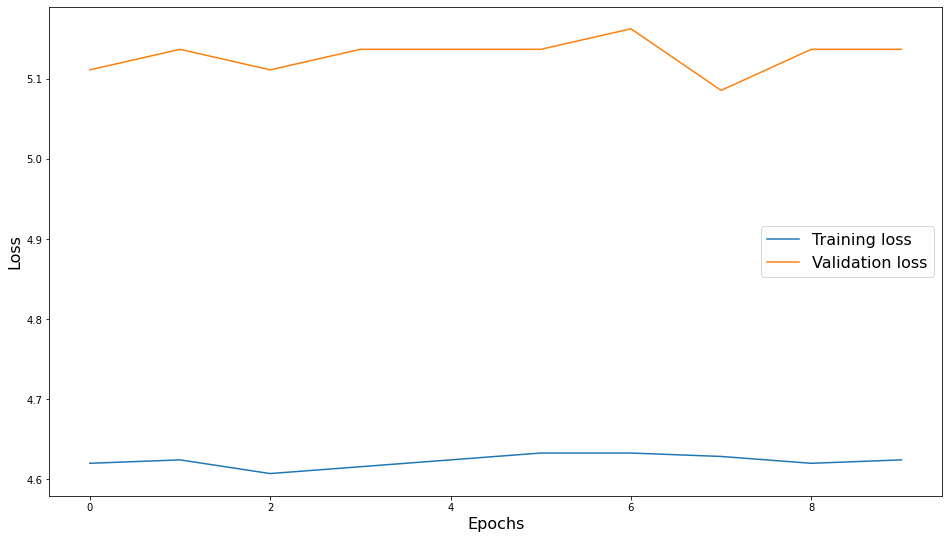

<Figure size 432x288 with 0 Axes>

In [10]:
plt.figure(figsize=(16,9))
plt.plot(np.arange(len(ta)), ta, va)
plt.legend(('Training loss', 'Validation loss'), fontsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()
plt.clf()